In [1]:
!nvidia-smi

Sun Jun 19 15:22:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
root_path = '/content/drive/MyDrive/Contest/Amazon/Data/dataset'
os.chdir(root_path)

In [3]:
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 4.9 MB 6.3 MB/s 
     |████████████████████████████████| 1.8 MB 5.3 MB/s 
     |████████████████████████████████| 352 kB 69.7 MB/s 
     |████████████████████████████████| 596 kB 47.7 MB/s 
     |████████████████████████████████| 92 kB 12.4 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 1.2 MB 45.0 MB/s 
     |████████████████████████████████| 1.1 MB 51.7 MB/s 
     |████████████████████████████████| 99 kB 10.4 MB/s 
     |████████████████████████████████| 237 kB 66.4 MB/s 
     |████████████████████████████████| 48.3 MB 1.2 MB/s 


In [4]:
import os
import shutil
import csv
import re
import tensorflow as tf
import numpy
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt
import pandas as pd

tf.get_logger().setLevel('ERROR')

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
!pip install contractions
import contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 106 kB 5.4 MB/s 
     |████████████████████████████████| 287 kB 33.1 MB/s 


In [7]:
data_raw = pd.read_pickle("data_mini.pkl")

In [9]:
data_raw.shape

(5000, 5)

In [8]:
data_raw.head()

,TITLE,DESCRIPTION,BULLET_POINTS,BRAND,BROWSE_NODE_ID
0,"Pete The Cat Bedtime Blues Doll, 14.5 Inch","Pete the Cat is the coolest, most popular cat ...","[Pete the Cat Bedtime Blues plush doll,Based o...",MerryMakers,0
1,"The New Yorker NYHM014 Refrigerator Magnet, 2 ...",The New Yorker Handsome Cello Wrapped Hard Mag...,[Cat In A Tea Cup by New Yorker cover artist G...,The New Yorker,1
3,Amway Nutrilite Kids Chewable Iron Tablets (100),,"[Nutrilite Kids,Chewable Iron Tablets,Quantity...",Amway,3
4,Teacher Planner Company A4 6 Lesson Academic T...,,,,4
5,Men'S Full Sleeve Raglan T-Shirts Denim T-Shir...,Men'S Full Sleeve Raglan T-Shirts Denim T-Shir...,"[Color: Blue,Sleeve: Full Sleeve,Material: Cot...",Bhavya Enterprise,5


In [ ]:
!pip install transformers

In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
label = data_raw['BROWSE_NODE_ID'].values
data = data_raw.drop(columns = ['BROWSE_NODE_ID']).values

In [11]:
def standardize_text(data):
  data = ' '.join(data)
  data = contractions.fix(data)
  data = re.sub(r"[^A-Za-z]", " ", data)
  data = data.lower()
  return data

In [12]:
data_processed = []
for d in data:
  temp = standardize_text(d)
  data_processed.append(temp)
data_processed = numpy.array(data_processed)

In [13]:
from sklearn.preprocessing import OneHotEncoder

In [14]:
label_t = label.reshape(-1,1)

In [15]:
onehot_encoder = OneHotEncoder(sparse=False)
label_encoded = onehot_encoder.fit_transform(label_t)

In [16]:
label_encoded.shape

(5000, 50)

In [17]:
test_ratio=0.2
random_st=40
dropout = 0.1 #can be different for different layers
batch = 16

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(data_processed, label_encoded, test_size=test_ratio, random_state=random_st, shuffle=True, stratify=label_encoded)

In [ ]:
X_test, X_val, Y_test, Y_val = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=random_st, shuffle=True, stratify=label_encoded)

ValueError: ignored

In [19]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'albert_en_base'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/albert_en_base/2
Preprocess model auto-selected: https://tfhub.dev/tensorflow/albert_en_preprocess/3


In [20]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [21]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [22]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(50, activation='relu', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [23]:
classifier_model = build_classifier_model()

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [24]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.CategoricalAccuracy()

In [25]:
epochs = 10
steps_per_epoch = X_train.shape[0]
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [26]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [27]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(X_train, Y_train, batch_size=batch, epochs=epochs, validation_data=(X_test, Y_test))

Training model with https://tfhub.dev/tensorflow/albert_en_base/2
Epoch 1/10
250/250 [==============================] - 159s 576ms/step - loss: 4.0248 - categorical_accuracy: 0.0262 - val_loss: 3.8992 - val_categorical_accuracy: 0.0320
Epoch 2/10
250/250 [==============================] - 148s 590ms/step - loss: 3.8129 - categorical_accuracy: 0.0655 - val_loss: 3.6437 - val_categorical_accuracy: 0.1480
Epoch 3/10
250/250 [==============================] - 148s 590ms/step - loss: 3.2695 - categorical_accuracy: 0.2528 - val_loss: 2.7414 - val_categorical_accuracy: 0.4450
Epoch 4/10
250/250 [==============================] - 148s 591ms/step - loss: 2.1123 - categorical_accuracy: 0.5705 - val_loss: 1.6543 - val_categorical_accuracy: 0.6640
Epoch 5/10
250/250 [==============================] - 148s 590ms/step - loss: 1.1408 - categorical_accuracy: 0.7720 - val_loss: 0.9893 - val_categorical_accuracy: 0.7740
Epoch 6/10
250/250 [==============================] - 148s 591ms/step - loss: 0.6601

In [ ]:
classifier_model.save('model_trained_wobrand')

In [28]:
data_raw_val = pd.read_pickle("data_val.pkl")
label_val = data_raw_val['BROWSE_NODE_ID'].values
data_val = data_raw_val.drop(columns=['BROWSE_NODE_ID']).values
#data_val = data_raw_val['TITLE'].values

In [29]:
data_val_processed = []
for d in data_val:
  data_val_processed.append(standardize_text(d))
data_val_processed = numpy.array(data_val_processed)

In [30]:
result = classifier_model.predict(data_val_processed)

In [31]:
result_t = onehot_encoder.inverse_transform(result)

In [ ]:
result_t[1][0]

4

In [32]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

In [33]:
acc = 0
for i in range(1000):
  if(result_t[i][0]==label_val[i]):
    acc += 1
print(acc/1000)

0.931


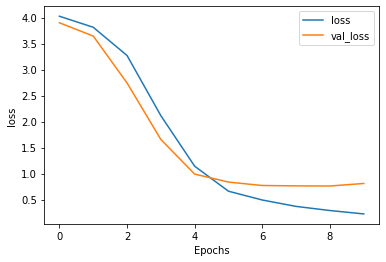

In [34]:
plot_graphs(history, 'loss')

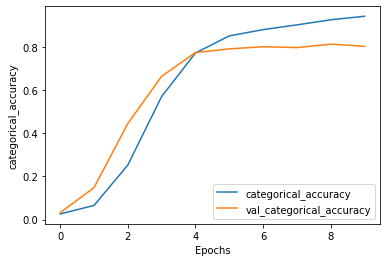

In [35]:
plot_graphs(history, 'categorical_accuracy')